# 4_Filtros: Estimación y Sustracción

Un método muy utilizado para filtrar es el de Estimación Sustracción (...)

Mediante este método lo que intentaremos es eliminar la linea de base, para eso se realiza una estimación de su valor y luego se lo resta a la señal corrompida.

Para la estimación se divide la señal en intervalos de 400ms, tomados desde 300ms antes y hasta 100ms despues de la ocurrencia de un complejo QRS, para cada uno se calcula la media y la mediana con el fin de analizar el método por dos parametros estadísticos distintos. Además se prueban otros dos metodos con la mediana, pero tomando solo una ventana de valores dentro de cada intervalo, es decir que en total realizan cuatro estimaciones de la linea de base, con el fin de analizar cual es el mejor estimador.

Las cuatro interpolaciones se llevan a cabo mediante la función interp1d, tomando el punto medio de cada intervalo como aquel en el cual el valor de la base de linea es la media o la mediana, dependiendo el caso, estimada con todo el intervalo

La ubicación de los complejos QRS es aportada por las anotaciones que tiene la estructura de matlab leída que contiene la señal

In [10]:
import warnings
warnings.filterwarnings('ignore')

import wfdb
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.interpolate as interpol


#------APERTURA DE LA SEÑAL-------
mat_struct = sio.loadmat('/home/luciasucunza/git_proyecto_ecg/Filtros/TP4_ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten(1)
qrs_detections = mat_struct['qrs_detections']
cant_muestras = len(ecg_one_lead)

fs = 1000 
nyq_frec = fs / 2
t = np.arange(cant_muestras) / fs

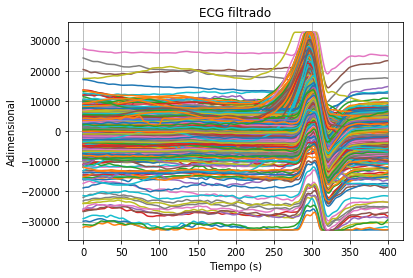

In [4]:
#------SEPARACION EN VENTANAS-------
ventana_inf_ms    = 300
ventana_sup_ms    = 100
ventana_len_ms    = ventana_inf_ms + ventana_sup_ms

ventana_inf       = int(ventana_inf_ms / 1000 * fs)
ventana_sup       = int(ventana_sup_ms / 1000 * fs)
ventana_len       = ventana_inf + ventana_sup 

mat = np.zeros(( ventana_len, len(qrs_detections)), dtype=int)

for j in range( len(qrs_detections) ):
    
    for i in range(ventana_len):    
        mat[i,j] = ecg_one_lead[ int(qrs_detections[j]) + i - ventana_inf  ]

        
#------Ploteo de Todos las ventanas-------
plt.figure('Todas las ventanas')
plt.plot( mat )
plt.title('ECG filtrado')
plt.ylabel('Adimensional')
plt.xlabel('Tiempo (s)')
plt.grid()
plt.show()

La separacion en ventanas de la señal se lleva a cabo mediante ciclos for, luego se imprimen todos los intervalos superpuestos y se puede notar como la line de base afecta de formas muy distintas a los distinos segmentos de la señal original

(...) EXPLICAR COMO ESTA FORMADA mat

In [6]:
#------Calculo de la mediana y de diferentes medias para cada ventana-------
mat_plantilla = np.zeros_like( mat )


median      = np.median(mat, axis=0)
mat_median  = median + mat_plantilla 


mean        = np.mean(mat, axis=0)
mat_mean    = mean + mat_plantilla 


mean_vent     = np.mean(mat[ 100:200 , :], axis=0)
mat_mean_vent = mean_vent + mat_plantilla 


mean_vent2     = np.mean(mat[ 50:250 , :], axis=0)
mat_mean_vent2 = mean_vent2 + mat_plantilla 

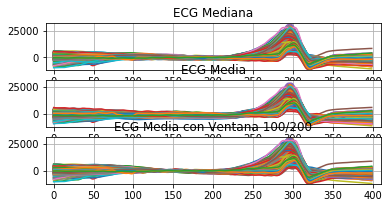

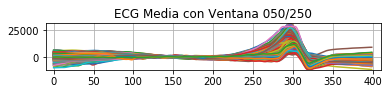

In [23]:
#------Resta de cada ventana de la señal ECG con los diferentes parámetros  -------
ecg_median      = mat - mat_median
ecg_mean        = mat - mat_mean
ecg_mean_vent   = mat - mat_mean_vent
ecg_mean_vent2  = mat - mat_mean_vent2


#------Ploteo de cada ventana de la señal ECG con los diferentes parámetros  -------
plt.figure('Ventanas con su correspondiente parametro restado')

plt.subplot(411)
plt.plot( ecg_median )
plt.title('ECG Mediana')
plt.grid()
plt.axis([-10, 410, -12000, 32000])

plt.subplot(412)
plt.plot( ecg_mean )
plt.title('ECG Media')
plt.grid()
plt.axis([-10, 410, -12000, 32000])

plt.subplot(413)
plt.plot( ecg_mean_vent )
plt.title('ECG Media con Ventana 100/200')
plt.grid()
plt.axis([-10, 410, -12000, 32000])
plt.show()

plt.subplot(414)
plt.plot( ecg_mean_vent )
plt.title('ECG Media con Ventana 050/250')
plt.grid()
plt.axis([-10, 410, -12000, 32000])
plt.show()

Este grafico nos muestra como al restarle a cada intervalo la media o la mediana estimada los intevalos comienzan a superponerse porque se reduce la linea de base 

Para llevar a cabo la interpolación mediante la funcion interp1d hay que tener en cuenta que no existen valores estimados para la primera y la última muestra, ya que los hay solo en las muestras que coinciden con la mitad de un intervalo, por eso es necsario definir un cierto valor de base de linea en los extremos. En este caso se elije repetir el valor más cercano, es decir el del primer intervalo y el del ultimo intervalo, aunque tambien se podría realizar otra elección

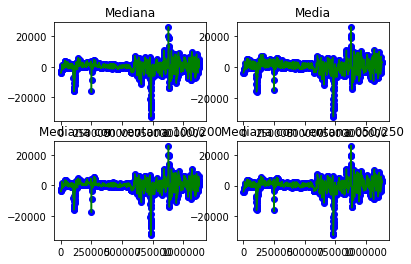

In [25]:
#------ Interpolacion -------
n_new       = np.arange( cant_muestras )

ni                      = np.zeros( len(qrs_detections)+2)
ni[0]                   = 0
ni[1:1904]              = ( qrs_detections[:,0] - ventana_inf_ms + int((ventana_len_ms)/2) )
ni[1904]                = cant_muestras

median_aux              = np.zeros( len(qrs_detections)+2)
median_aux[0]           = median[0] 
median_aux[1:1904]      = median
median_aux[1904]        = median[1902]

mean_aux                = np.zeros( len(qrs_detections)+2)
mean_aux[0]             = mean[0] 
mean_aux[1:1904]        = mean
mean_aux[1904]          = mean[1902]

mean_vent_aux           = np.zeros( len(qrs_detections)+2)
mean_vent_aux[0]        = mean_vent[0] 
mean_vent_aux[1:1904]   = mean_vent
mean_vent_aux[1904]     = mean_vent[1902]

mean_vent2_aux          = np.zeros( len(qrs_detections)+2)
mean_vent2_aux[0]       = mean_vent2[0] 
mean_vent2_aux[1:1904]  = mean_vent2
mean_vent2_aux[1904]    = mean_vent2[1902]


f= interpol.interp1d( ni, median_aux,       kind='cubic')
y_median        = f(n_new)

f= interpol.interp1d( ni, mean_aux,         kind='cubic')
y_mean          = f(n_new)

f= interpol.interp1d( ni, mean_vent_aux,    kind='cubic')
y_mean_vent     = f(n_new)

f= interpol.interp1d( ni, mean_vent2_aux,   kind='cubic')
y_mean_vent2    = f(n_new)


#------ Ploteo Interpolacion -------
plt.figure('Interpolacion de los parametros de cada ventana')
plt.subplot(221)
plt.title('Mediana')
plt.plot( ni, median_aux,     'bo', n_new, y_median,     'g' )
plt.subplot(222)
plt.title('Media')
plt.plot( ni, mean_aux,       'bo', n_new, y_mean,       'g' )
plt.subplot(223)
plt.title('Mediana con ventana 100/200')
plt.plot( ni, mean_vent_aux,  'bo', n_new, y_mean_vent,  'g' )
plt.subplot(224)
plt.title('Mediana con ventana 050/250')
plt.plot( ni, mean_vent2_aux, 'bo', n_new, y_mean_vent2, 'g' )
plt.show()

En estos graficos podemos ver en azul todos los valores de la media o mediana ubicados en el punto medio de cada intervalo y en verde la función que queda al interpolar estos puntos, es decir la linea de base estimada mediante cada estimador

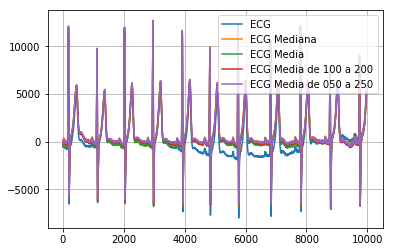

In [16]:
#------ Obtencion de ECG sin BL  -------
ecg_median     = ecg_one_lead - y_median
ecg_mean       = ecg_one_lead - y_mean
ecg_mean_vent  = ecg_one_lead - y_mean_vent
ecg_mean_vent2 = ecg_one_lead - y_mean_vent2


#------ Ploteo de ECG sin BL  -------
zoom_region = np.arange( 10000, 20000, dtype='uint')

plt.figure('Señales Obtenidas')
plt.plot( ecg_one_lead[zoom_region],     label='ECG'                   )
plt.plot( ecg_median[zoom_region],       label='ECG Mediana'           )
plt.plot( ecg_mean[zoom_region],         label='ECG Media'             )
plt.plot( ecg_mean_vent[zoom_region],    label='ECG Media de 100 a 200')
plt.plot( ecg_mean_vent2[zoom_region],   label='ECG Media de 050 a 250')
plt.grid()
plt.legend()
plt.show()

Es posible notar que es un buen filtrado ya que la forma de onda no se modifica ni se produce el rigning que ocurría en el caso de PA+PB, seguiremos de todas formas analizando otros metodos para encontrar cual es el más eficiente para el filtrado de señales ECG